<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<center><h1>Técnicas de Inteligencia Artificial</header1></center>
<left><h1>Actividad 1. Laboratorio: Árboles de decisión, reglas y ensemble learning</header1></left>

Presentado por: Yerson Emel Gulloso Moyano  <br>
Fecha: 06/02/2023

## Importación de librerias necesarias

In [321]:
#Para esta actividad se importarán las siguientes librerías:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.tree import  plot_tree
from sklearn.model_selection import train_test_split
from sklearn.tree import  DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


## Cargar el Dataset

In [355]:
#Código para cargar el Dataset
# verificar que el archivo se encuentre en la misma ruta del notebook
url = './Laboratorio_dataset_car.csv'
df_raw = pd.read_csv(url, header=None, names=["dataset"])
df_raw.head()


,dataset
0,Buying;Maintenance;Doors;Person;lug_boot;safet...
1,vhigh;vhigh;2;2;small;low;unacc
2,vhigh;vhigh;2;2;small;med;unacc
3,vhigh;vhigh;2;2;small;high;unacc
4,vhigh;vhigh;2;2;med;low;unacc


### Limpieza del dataset

Separar los datos por ";" para crear un Dataframe a partir de las instancias registradas.

In [323]:
# separar por ";"
df = list(df_raw["dataset"].apply(lambda x:x.split(';')))
# extraer el primer registro como cabecera
header = df.pop(0)
# crear un nuevo DF
df_clean = pd.DataFrame(data=df, columns=header)
df_clean.tail()

,Buying,Maintenance,Doors,Person,lug_boot,safety,class
1745,low,low,5more,more,med,high,vgood
1746,low,low,5more,more,med,high,vgood
1747,low,low,5more,more,big,low,unacc
1748,low,low,5more,more,big,med,good
1749,low,low,5more,more,big,high,vgood


## Caracterización del Dataset

In [324]:
# Cantidad de instancias en total
print('-'*45)
total_instancias = len(df_clean)
print(f'Total de instancias: {total_instancias}')
# total instancias por clase
print('-'*45)
total_por_clase = df_clean.count()
print(f'Total de instancias para cada clase: \n{total_por_clase}')
# cantidad de atributos de entrada
print('-'*45)
cantidad_atributos = len(df_clean.columns)
print(f'Cantidad de atributos de entrada: {cantidad_atributos}')
# tipos de datos
print('-'*45)
print(f'Tipo de cada atributo: \n{df_clean.dtypes}')
# exploración de datos nulos o desconocidos
print('-'*45)
datos_nulos = df_clean.isnull().sum().sum()
print(f'Cantidad de datos desconocidos: {datos_nulos}')


---------------------------------------------
Total de instancias: 1750
---------------------------------------------
Total de instancias para cada clase: 
Buying         1750
Maintenance    1750
Doors          1750
Person         1750
lug_boot       1750
safety         1750
class          1750
dtype: int64
---------------------------------------------
Cantidad de atributos de entrada: 7
---------------------------------------------
Tipo de cada atributo: 
Buying         object
Maintenance    object
Doors          object
Person         object
lug_boot       object
safety         object
class          object
dtype: object
---------------------------------------------
Cantidad de datos desconocidos: 0


## Exploración del Dataset

In [344]:
# contador de calificación de conformidad
df_clean["class"].value_counts()

unacc    1215
acc       390
good       75
vgood      70
Name: class, dtype: int64

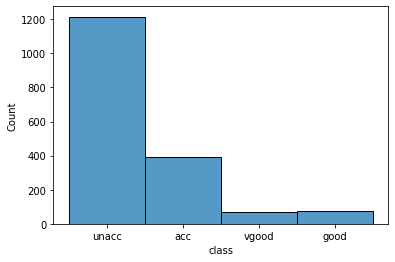

In [326]:
sns.histplot(df_clean["class"]);

Agrupación y gráfico de la variable Maintenance = low

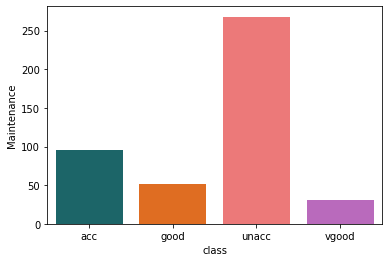

In [342]:
more_buy = df_clean["Maintenance"] == "low" 
df_c = df_clean[more_buy]
df_c = df_c[['Maintenance', 'class']].groupby("class").count().reset_index()
colores = {
    'acc':'#0f7175ff',
    'unacc':'#ff66666f',
    'good':'#ff6602ff',
    'vgood':'#c65dc9ff'
}
sns.barplot(data=df_c, x='class',y='Maintenance', palette=colores);

Agrupación y gráfico de la variable Safety = high

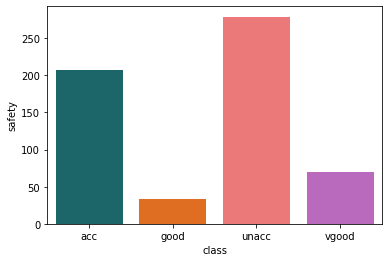

In [343]:
more_buy = df_clean["safety"] == "high" 
df_c = df_clean[more_buy]
df_c = df_c[['safety', 'class']].groupby("class").count().reset_index()
colores = {
    'acc':'#0f7175ff',
    'unacc':'#ff66666f',
    'good':'#ff6602ff',
    'vgood':'#c65dc9ff'
}
sns.barplot(data=df_c, x='class',y='safety', palette=colores);

## Preprocesamiento del dataset. Transformaciones previas necesarias para la modelación

Codificación binaria OneHotEncoder aplicada a las variables seleccionadas ['Maintenance', 'Person', 'safety'], cada columna de tipo object o categórica es transformada a tipo float.

In [329]:
#Código que realice las transformaciones necesarias para poder realizar los procesos de modelación. Ej.One hot enconding
# codificación
df = df_clean[['class','Maintenance','Person','safety']]
data_tf = df.copy()

def encoder(df, col):
    encoder = pd.get_dummies(df[col], prefix=col)
    df = df.drop(col, axis =1)
    df = pd.concat([df,encoder], axis=1)
    return df

In [330]:
df2 = encoder(data_tf,'Maintenance')
df4 = encoder(df2,'Person')
df_end = encoder(df4,'safety')

## División del dataset en datos de entrenamiento y datos de test 

Dividiendo el dataset en datos de entrenamiento (80%) y datos de test (20%)

In [331]:
#Código que realice la división en entrenamiento y test, de acuerdo con la estretgia de evluación planeada. Describa cuál es.
X = df_end.drop(['class'], axis=1)
y = df_end['class']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

## Ajuste de los modelos de clasificación propuestos

### Arbol de Decisión de Clasificación

In [332]:
#Código de ajuste del modelo de clasificación 1
model_tree = DecisionTreeClassifier(max_depth=5)
model_tree_fit = model_tree.fit(X_train, y_train)

Generando el diagrama de arbol con profundidad de 5 (5 nodos)

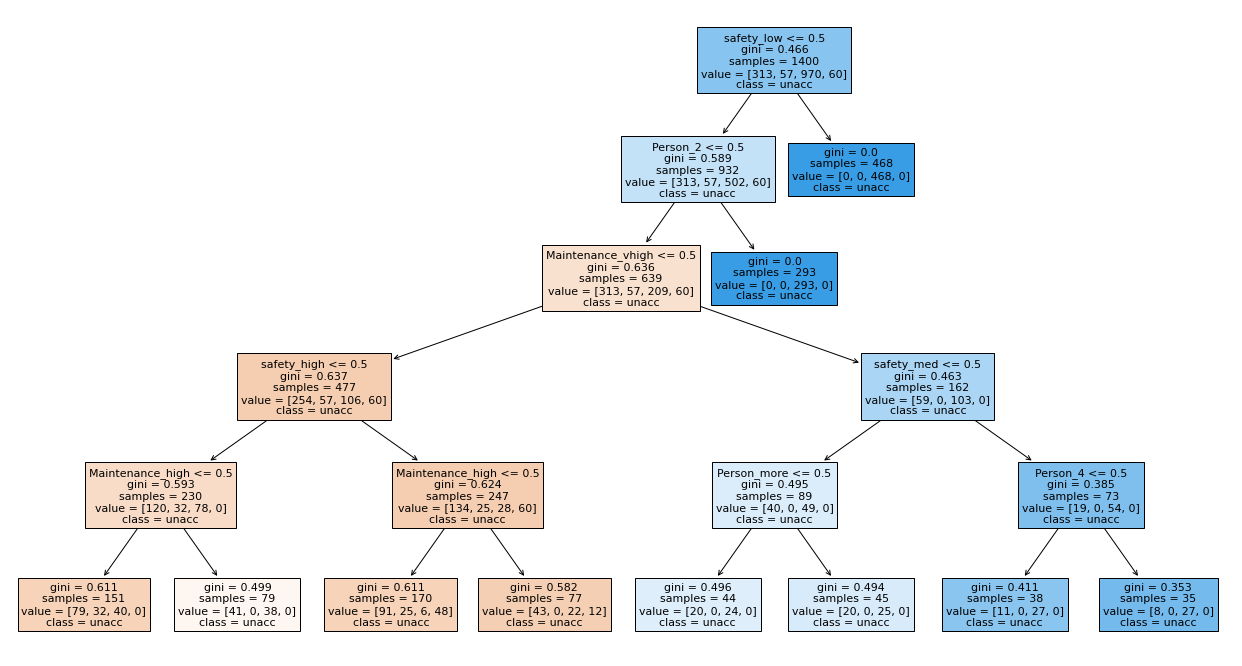

In [333]:
plt.figure(figsize=(22,12))
plot_tree(decision_tree=model_tree_fit, feature_names=list(X.columns.values), class_names=list(y.values),filled=True, fontsize=11);

### Random forest

Entrenando el modelo

In [348]:
# estimadores = 20 arbolores de decision
# criterio = entropy
model_RF = RandomForestClassifier(n_estimators=20,random_state=123,criterion='entropy')
model_RF_fit = model_RF.fit(X_train,y_train)

## Evaluación de cada modelo

### Precisión Arbol de decisión de clasificación

In [349]:
# prediciones el modelo en base a los datos de prueba
y_pred = model_tree_fit.predict(X_test)

In [350]:
# precision del modelo
print(accuracy_score(y_test,y_pred))

0.8142857142857143


Prueba de muestra aleatoria

In [360]:
# generar muestra aleatoria
muestra = X.sample()
print(muestra.values)
# se aplica para predecir la variable objetivo
print('Resultado: ',model_tree_fit.predict(muestra))

[[0 0 1 0 0 0 1 1 0 0]]
Resultado:  ['acc']


### Matriz de confusión

In [336]:
max_conf = confusion_matrix(y_test, y_pred)
max_conf

array([[ 64,   0,  13,   0],
       [ 18,   0,   0,   0],
       [ 24,   0, 221,   0],
       [ 10,   0,   0,   0]])

### Precisión del modelo Random Forest

In [353]:
# predición del modelo en base a los datos de prueba
y_pred_2 = model_RF_fit.predict(X_test)

In [354]:
# precision del modelo
print(accuracy_score(y_test,y_pred_2))

0.8114285714285714


Prueba de muestra aleatoria

In [359]:
# generar muestra aleatoria
muestra = X.sample()
print(muestra.values)
# se aplica para predecir la variable objetivo
print('Resultado: ',model_RF_fit.predict(muestra))

[[0 0 0 1 1 0 0 0 1 0]]
Resultado:  ['unacc']


### Matriz de confusión

In [340]:
max_conf_2 = confusion_matrix(y_test, y_pred_2)
max_conf_2

array([[ 59,   0,  18,   0],
       [ 18,   0,   0,   0],
       [ 20,   0, 225,   0],
       [ 10,   0,   0,   0]])

## Comparación del desempeño de modelos

Comparar modelos mediante una validación cruzada segmentada en 10 trozos

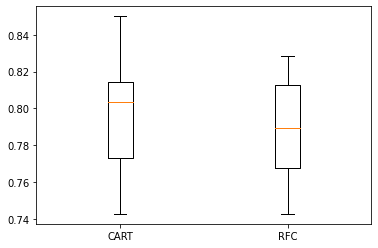

In [364]:
madels = []
madels.append(('CART', DecisionTreeClassifier()))
madels.append(('RFC', RandomForestClassifier(n_estimators=20,random_state=123, criterion='entropy')))
results = []
names = []

for i, model in madels:
    kfold = StratifiedKFold(n_splits=10, random_state=1,shuffle=True)
    cv_results = cross_val_score(model,X_train,y_train,cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(i)

plt.boxplot(results, labels=names);